In [134]:
# First we import the necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [135]:
# Load the dataset:
df = pd.read_csv('yearly_full_release_long_format.csv')
df.columns = df.columns.str.strip().str.replace('"', '')
if df.columns[0] == '':
    df = df.drop(columns=df.columns[0])

df = df.replace("..", np.nan)

for c in ['year', 'value', 'yoy_absolute_change', 'yoy__change']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

for c in ['area','iso_3_code','area_type','continent','ember_region','category','subcategory','variable','unit']:
    if c in df.columns:
        df[c] = df[c].astype('string')

for c in ['eu','oecd','g20','g7','asean']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)

df = df.drop(columns=[c for c in ['ember_region','eu','oecd','g20','g7','asean','yoy_absolute_change','yoy__change'] if c in df.columns])

cat = df['category'].fillna('').str.lower()
var = df['variable'].fillna('').str.lower()

cond_prod = cat.str.contains('generation') | var.str.contains('generation') | cat.str.contains('production')
cond_cons = cat.str.contains('demand') | var.str.contains('consumption') | var.str.contains('demand')

df['energy_type'] = np.select([cond_prod, cond_cons], ['Production','Consumption'], default=None)
df['energy_type'] = pd.Series(df['energy_type'], dtype='string')

df = df[['area','iso_3_code','year','category','subcategory','variable','energy_type','unit','value']]

df = df.dropna(subset=['unit','value']).reset_index(drop=True)

df['year'] = df['year'].astype('Int64')
df['value'] = pd.to_numeric(df['value'], errors='coerce').astype(float)

# Asegurar que las columnas tengan los tipos correctos
df['variable'] = df['variable'].astype('string')
df['unit'] = df['unit'].astype('string')
df = df.drop(columns=['energy_type'])

In [136]:
# Display the first few rows of the dataset:
df.head()

,area,iso_3_code,year,category,subcategory,variable,unit,value
0,Afghanistan,AFG,2000,Capacity,Aggregate fuel,Clean,GW,0.19
1,Afghanistan,AFG,2000,Capacity,Aggregate fuel,Fossil,GW,0.03
2,Afghanistan,AFG,2000,Capacity,Aggregate fuel,Gas and Other Fossil,GW,0.03
3,Afghanistan,AFG,2000,Capacity,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",GW,0.19
4,Afghanistan,AFG,2000,Capacity,Aggregate fuel,Renewables,GW,0.19


In [137]:
# Check the shape of the dataset:
df.shape

(337309, 8)

In [138]:
# Check the attribute names:
df.columns

Index(['area', 'iso_3_code', 'year', 'category', 'subcategory', 'variable',
       'unit', 'value'],
      dtype='object')

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337309 entries, 0 to 337308
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   area         337309 non-null  string 
 1   iso_3_code   316209 non-null  string 
 2   year         337309 non-null  Int64  
 3   category     337309 non-null  string 
 4   subcategory  337309 non-null  string 
 5   variable     337309 non-null  string 
 6   unit         337309 non-null  string 
 7   value        337309 non-null  float64
dtypes: Int64(1), float64(1), string(6)
memory usage: 20.9 MB


array([[<Axes: title={'center': 'value'}>]], dtype=object)

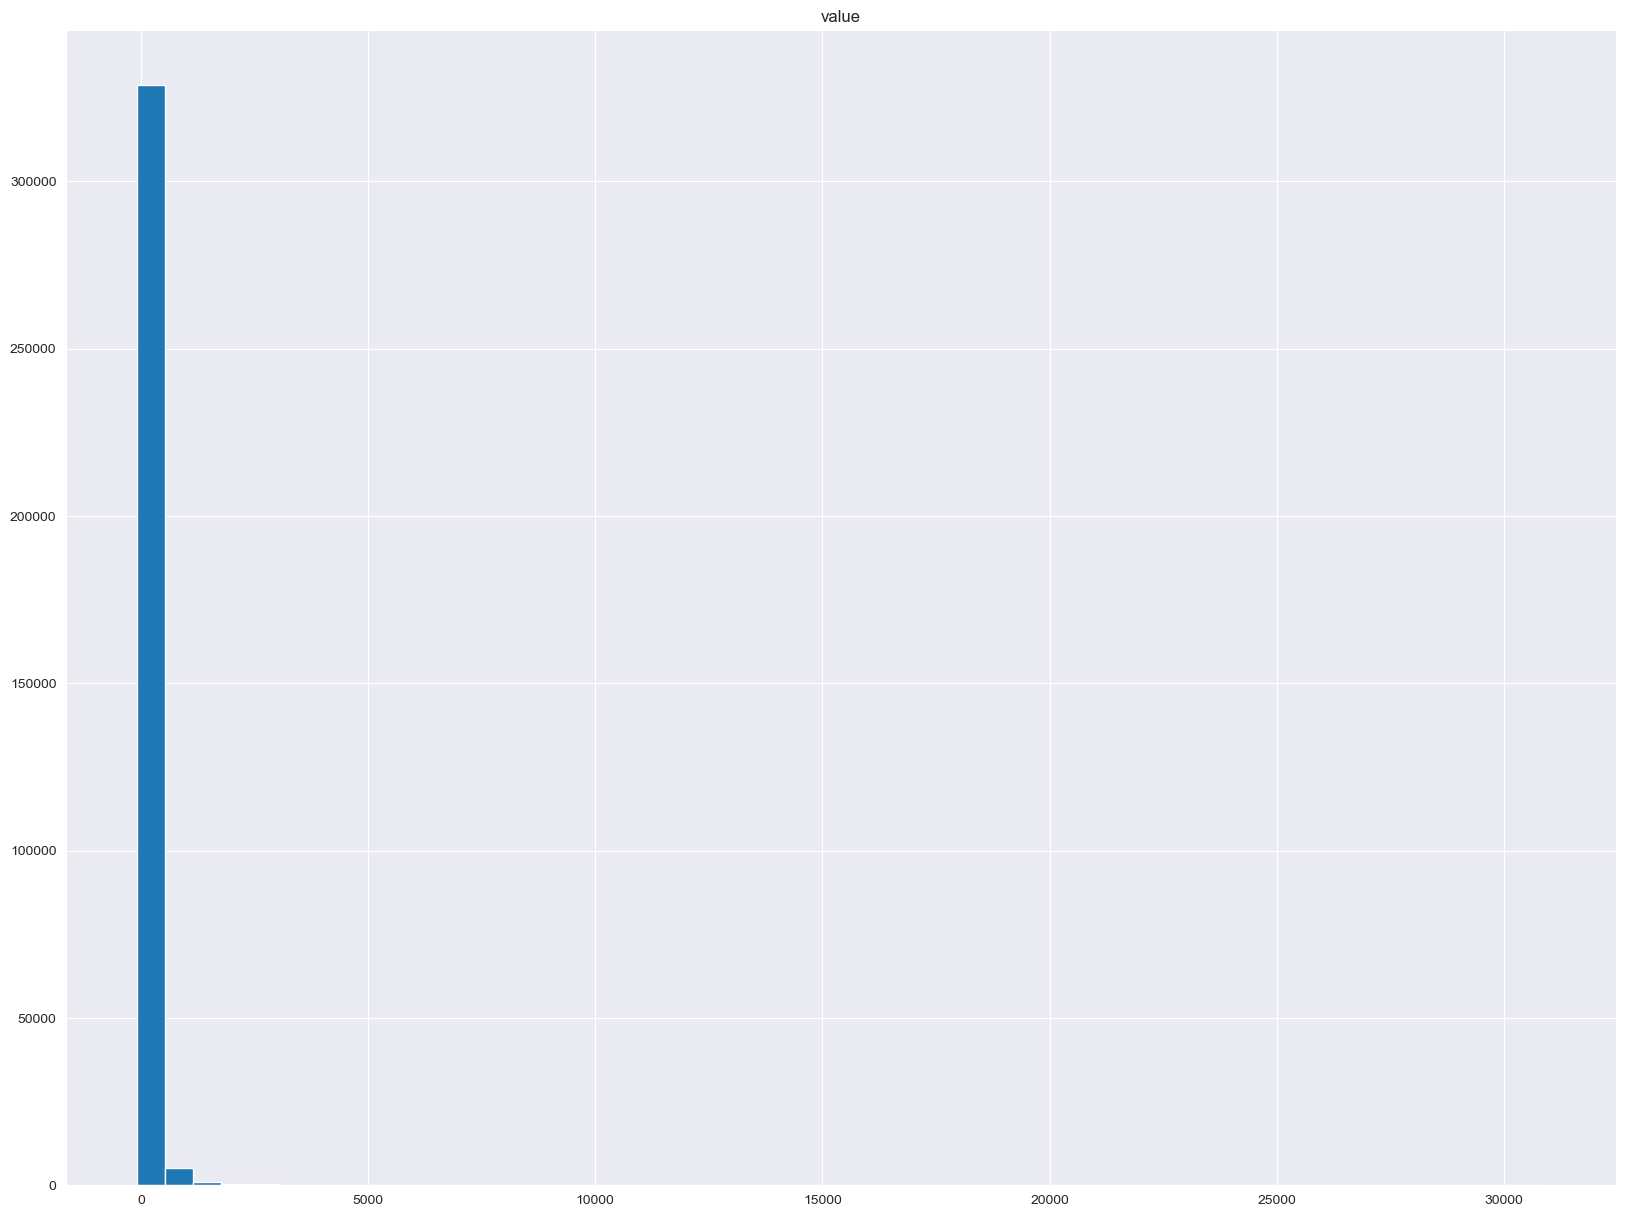

In [140]:
# Check the histograms of numerical attributes:
df.iloc[:, 5:].hist(bins=50, figsize=(20, 15))

In [141]:
print(df.isnull().sum())

area               0
iso_3_code     21100
year               0
category           0
subcategory        0
variable           0
unit               0
value              0
dtype: int64


In [142]:
categorical_cols = ['area', 'iso_3_code', 'category', 'subcategory', 'variable', 'unit']
for col in categorical_cols:
    if col in df.columns:
        unique_count = df[col].nunique()
        print(f"  {col}: {unique_count} valores únicos")

  area: 228 valores únicos
  iso_3_code: 215 valores únicos
  category: 5 valores únicos
  subcategory: 7 valores únicos
  variable: 21 valores únicos
  unit: 6 valores únicos


In [143]:
combinations = df.groupby(['category', 'subcategory', 'variable']).size().reset_index(name='count')
print(f"  Total de combinaciones: {len(combinations)}")
print("\nPrimeras 10 combinaciones:")
print(combinations.head(10))

  Total de combinaciones: 51

Primeras 10 combinaciones:
   category     subcategory                               variable  count
0  Capacity  Aggregate fuel                                  Clean   5395
1  Capacity  Aggregate fuel                                 Fossil   5431
2  Capacity  Aggregate fuel                   Gas and Other Fossil   5289
3  Capacity  Aggregate fuel  Hydro, Bioenergy and Other Renewables   4576
4  Capacity  Aggregate fuel                             Renewables   5395
5  Capacity  Aggregate fuel                         Wind and Solar   5362
6  Capacity            Fuel                              Bioenergy   3800
7  Capacity            Fuel                                   Coal   2453
8  Capacity            Fuel                                    Gas   3396
9  Capacity            Fuel                                  Hydro   4223


In [144]:
original_size = len(df)

# Estrategia 1: Eliminar filas donde el valor de interés (value) es nulo
df_clean = df.dropna(subset=['value']).copy()
print(
  f"\n1. Después de eliminar filas con 'value' nulo: {len(df_clean)} filas ({len(df_clean) / original_size * 100:.2f}%)")

# Estrategia 2: Para columnas categóricas, reemplazar NaN con 'Unknown' o categoría específica
for col in ['area', 'iso_3_code', 'category', 'subcategory', 'variable', 'unit']:
  if col in df_clean.columns:
    null_count = df_clean[col].isnull().sum()
    if null_count > 0:
      df_clean[col] = df_clean[col].fillna('Unknown')
      print(f"2. Columna '{col}': {null_count} valores nulos reemplazados por 'Unknown'")

# Estrategia 3: Para year, podríamos imputar o eliminar (depende del contexto)
if df_clean['year'].isnull().sum() > 0:
  print(f"\n3. Filas con 'year' nulo: {df_clean['year'].isnull().sum()}")
  df_clean = df_clean.dropna(subset=['year'])
  print(f"   Después de eliminar: {len(df_clean)} filas")

print(f"\nFilas finales después de limpieza: {len(df_clean)}")

print("\n" + "=" * 80)
print("ANÁLISIS DE VARIANZA POR CATEGORÍAS")
print("=" * 80)

# Calcular estadísticas descriptivas por cada combinación categórica relevante
print("\n1. Estadísticas por CATEGORY:")
stats_category = df_clean.groupby('category')['value'].agg([
  ('count', 'count'),
  ('mean', 'mean'),
  ('std', 'std'),
  ('min', 'min'),
  ('max', 'max'),
  ('cv', lambda x: x.std() / x.mean() if x.mean() != 0 else 0)  # Coeficiente de variación
]).round(4)
print(stats_category)

print("\n2. Estadísticas por SUBCATEGORY:")
stats_subcategory = df_clean.groupby('subcategory')['value'].agg([
  ('count', 'count'),
  ('mean', 'mean'),
  ('std', 'std'),
  ('cv', lambda x: x.std() / x.mean() if x.mean() != 0 else 0)
]).round(4)
print(stats_subcategory)

print("\n3. Estadísticas por UNIT (unidad de medida):")
stats_unit = df_clean.groupby('unit')['value'].agg([
  ('count', 'count'),
  ('mean', 'mean'),
  ('std', 'std'),
  ('cv', lambda x: x.std() / x.mean() if x.mean() != 0 else 0)
]).round(4)
print(stats_unit)

print("\n" + "=" * 80)
print("DETECCIÓN Y TRATAMIENTO DE OUTLIERS")
print("=" * 80)


def detect_outliers_by_group(df, group_cols, value_col, method='iqr', threshold=1.5):
  """
  Detecta outliers dentro de cada grupo categórico
  method: 'iqr' o 'zscore'
  """
  outliers_mask = pd.Series([False] * len(df), index=df.index)

  for group_name, group_data in df.groupby(group_cols):
    values = group_data[value_col]

    if method == 'iqr':
      Q1 = values.quantile(0.25)
      Q3 = values.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - threshold * IQR
      upper_bound = Q3 + threshold * IQR
      group_outliers = (values < lower_bound) | (values > upper_bound)
    elif method == 'zscore':
      z_scores = np.abs((values - values.mean()) / values.std())
      group_outliers = z_scores > threshold

    outliers_mask.loc[group_data.index] = group_outliers

  return outliers_mask


# Detectar outliers por combinación de category-unit
print("1. Detectando outliers por método IQR (por category-unit)...")
outliers_iqr = detect_outliers_by_group(df_clean, ['category', 'unit'], 'value', method='iqr', threshold=1.5)
print(f"   Outliers detectados: {outliers_iqr.sum()} ({outliers_iqr.sum() / len(df_clean) * 100:.2f}%)")

# Mostrar algunos ejemplos de outliers
if outliers_iqr.sum() > 0:
  print("\nEjemplos de outliers detectados:")
  print(df_clean[outliers_iqr][['area', 'year', 'category', 'subcategory', 'variable', 'unit', 'value']].head(10))

# Opción: Eliminar outliers (si es apropiado para tu análisis)
df_no_outliers = df_clean[~outliers_iqr].copy()
print(f"\n2. Después de eliminar outliers: {len(df_no_outliers)} filas")

print("\n" + "=" * 80)
print("NORMALIZACIÓN DE VALORES POR GRUPO")
print("=" * 80)

# Crear columnas normalizadas por grupo
df_normalized = df_clean.copy()

# Normalización min-max por grupo (category-unit) - Método alternativo más eficiente
print("1. Aplicando normalización Min-Max por category-unit...")

# Calcular min y max por grupo
group_stats = df_normalized.groupby(['category', 'unit'])['value'].agg(['min', 'max']).reset_index()
group_stats.columns = ['category', 'unit', 'value_min', 'value_max']

# Hacer merge con el dataframe original
df_normalized = df_normalized.merge(group_stats, on=['category', 'unit'], how='left')

# Aplicar normalización
df_normalized['value_normalized'] = np.where(
  df_normalized['value_max'] - df_normalized['value_min'] != 0,
  (df_normalized['value'] - df_normalized['value_min']) / (df_normalized['value_max'] - df_normalized['value_min']),
  0
)

# Eliminar columnas auxiliares
df_normalized = df_normalized.drop(columns=['value_min', 'value_max'])

# Z-score estandarización por grupo
print("2. Aplicando estandarización Z-score por category-unit...")

# Calcular media y desviación estándar por grupo
group_stats = df_normalized.groupby(['category', 'unit'])['value'].agg(['mean', 'std']).reset_index()
group_stats.columns = ['category', 'unit', 'value_mean', 'value_std']

# Hacer merge con el dataframe
df_normalized = df_normalized.merge(group_stats, on=['category', 'unit'], how='left')

# Aplicar estandarización
df_normalized['value_standardized'] = np.where(
  df_normalized['value_std'] != 0,
  (df_normalized['value'] - df_normalized['value_mean']) / df_normalized['value_std'],
  0
)

# Eliminar columnas auxiliares
df_normalized = df_normalized.drop(columns=['value_mean', 'value_std'])

print("\nPrimeras filas con valores normalizados:")
print(df_normalized[['area', 'year', 'category', 'unit', 'value', 'value_normalized', 'value_standardized']].head(10))

print("\n" + "=" * 80)
print("MANEJO DE VARIANZA HETEROGÉNEA")
print("=" * 80)

# Análisis de varianza por unidad de medida
print("1. Coeficiente de variación por unidad:")
cv_by_unit = df_clean.groupby('unit')['value'].apply(
  lambda x: x.std() / x.mean() if x.mean() != 0 else 0
).sort_values(ascending=False)
print(cv_by_unit)

# Transformación logarítmica para valores con alta varianza (si todos son positivos)
print("\n2. Aplicando transformación logarítmica donde sea apropiado...")
df_transformed = df_clean.copy()

# Solo para valores positivos
positive_mask = df_transformed['value'] > 0
if positive_mask.sum() > 0:
  df_transformed.loc[positive_mask, 'value_log'] = np.log1p(df_transformed.loc[positive_mask, 'value'])
  print(f"   Transformación aplicada a {positive_mask.sum()} valores positivos")

print("\n" + "=" * 80)
print("REESTRUCTURACIÓN DE DATOS")
print("=" * 80)

# Crear tabla pivote: áreas x años x categorías
print("1. Creando tabla pivote por category...")
pivot_category = df_clean.pivot_table(
  values='value',
  index=['area', 'year'],
  columns='category',
  aggfunc='sum'
).reset_index()
print(f"   Dimensiones: {pivot_category.shape}")
print("\nPrimeras filas:")
print(pivot_category.head())

# Tabla pivote más detallada
print("\n2. Creando tabla pivote por subcategory-variable...")
pivot_detailed = df_clean.pivot_table(
  values='value',
  index=['area', 'year'],
  columns=['category', 'subcategory'],
  aggfunc='sum'
).reset_index()
print(f"   Dimensiones: {pivot_detailed.shape}")

print("\n" + "=" * 80)
print("VERIFICACIÓN FINAL")
print("=" * 80)

print(f"\n1. Conjunto de datos limpio:")
print(f"   - Filas: {len(df_clean)}")
print(f"   - Columnas: {len(df_clean.columns)}")
print(f"   - Valores nulos restantes: {df_clean.isnull().sum().sum()}")

print(f"\n2. Conjunto de datos normalizado:")
print(f"   - Filas: {len(df_normalized)}")
print(f"   - Nuevas columnas: value_normalized, value_standardized")

print("\n3. Información del DataFrame limpio:")
df_clean.info()


1. Después de eliminar filas con 'value' nulo: 337309 filas (100.00%)
2. Columna 'iso_3_code': 21100 valores nulos reemplazados por 'Unknown'

Filas finales después de limpieza: 337309

ANÁLISIS DE VARIANZA POR CATEGORÍAS

1. Estadísticas por CATEGORY:
                         count      mean        std    min       max        cv
category                                                                      
Capacity                 61848   32.1913   184.0743   0.00   4847.31    5.7181
Electricity demand       10998  247.8252  1691.5128   0.00  30913.94    6.8254
Electricity generation  167302   70.3617   610.3119   0.00  30913.94    8.6739
Electricity imports       5199    0.0385     8.5808 -89.85     66.67  223.0241
Power sector emissions   91962   78.2930   509.5504   0.00  14620.96    6.5082

2. Estadísticas por SUBCATEGORY:
                      count      mean        std        cv
subcategory                                               
Aggregate fuel       130448   68.7724   5

In [145]:
# Save the cleaned dataset:
df.to_csv('yearly_full_release_long_format_clean.csv', index=False)

In [146]:
df = pd.read_csv('yearly_full_release_long_format_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337309 entries, 0 to 337308
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   area         337309 non-null  object 
 1   iso_3_code   316209 non-null  object 
 2   year         337309 non-null  int64  
 3   category     337309 non-null  object 
 4   subcategory  337309 non-null  object 
 5   variable     337309 non-null  object 
 6   unit         337309 non-null  object 
 7   value        337309 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.6+ MB
